# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import json
import pickle

2025-08-28 01:44:16.842491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756345457.027928      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756345457.083615      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Reading

In [2]:
# Dataset source: https://www.kaggle.com/datasets/stanfordu/stanford-question-answering-dataset
train_file = '/kaggle/input/train-v1.1.json'
dev_file = '/kaggle/input/dev-v1.1.json'

def load_prepare_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    records = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                answers = {
                    "text": [ans['text'] for ans in qa['answers']],
                    "answer_start": [ans['answer_start'] for ans in qa['answers']],
                }
                records.append({
                    "id": qa["id"],  # Ensure to use the ID if available
                    "title": article["title"],
                    "context": context,
                    "question": question,
                    "answers": answers,
                })
    return records


train_data = load_prepare_data(train_file)
dev_data = load_prepare_data(dev_file)


train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
validation_dataset = Dataset.from_pandas(pd.DataFrame(dev_data))

squad = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset
})

# BERT Preprocessing & Training

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [5]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [6]:
batch_size = 8
num_epochs = 3
total_train_steps = (len(tokenized_squad["train"]) // batch_size) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

I0000 00:00:1756345531.058185      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
model = TFAutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_squad["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_squad["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)

In [9]:
history_bert = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3


I0000 00:00:1756345569.183433      71 service.cc:148] XLA service 0x7c5695cc2990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756345569.184017      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756345569.262470      71 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756345569.394208      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5474/5474 [==============================] - 4382s 792ms/step - loss: 1.2542 - val_loss: 1.0026
Epoch 2/3
5474/5474 [==============================] - 4338s 793ms/step - loss: 0.7540 - val_loss: 0.9906
Epoch 3/3
5474/5474 [==============================] - 4337s 792ms/step - loss: 0.5010 - val_loss: 1.0897


In [10]:
tokenizer.save_pretrained('my_first_QA_model_bert_base')
model.save_pretrained('my_first_QA_model_bert_base')

# ALBERT Preprocessing & Training

In [11]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

data_collator = DefaultDataCollator(return_tensors="tf")

total_train_steps = (len(tokenized_squad["train"]) // batch_size) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [12]:
model = TFAutoModelForQuestionAnswering.from_pretrained("albert-base-v2")

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFAlbertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_squad["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_squad["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)

In [14]:
history_albert = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
5474/5474 [==============================] - 4145s 755ms/step - loss: 1.0168 - val_loss: 0.9506
Epoch 2/3
5474/5474 [==============================] - 4124s 753ms/step - loss: 0.7230 - val_loss: 0.8973
Epoch 3/3
5474/5474 [==============================] - 4128s 754ms/step - loss: 0.5431 - val_loss: 0.9521


In [15]:
tokenizer.save_pretrained('my_first_QA_model_albert_base')
model.save_pretrained('my_first_QA_model_albert_base')

# roBERTa Preprocessing & Training

In [16]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def preprocess_function_roberta(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)

        # context tokens have sequence_id=1 for RoBERTa too
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_squad = squad.map(preprocess_function_roberta, batched=True, remove_columns=squad["train"].column_names)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [17]:
data_collator = DefaultDataCollator(return_tensors="tf")

total_train_steps = (len(tokenized_squad["train"]) // batch_size) * num_epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps,
)

In [18]:
model = TFAutoModelForQuestionAnswering.from_pretrained("roberta-base")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForQuestionAnswering: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_squad["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_squad["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)

In [20]:
history_roberta = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
5474/5474 [==============================] - 4397s 796ms/step - loss: 1.0480 - val_loss: 0.8686
Epoch 2/3
5474/5474 [==============================] - 4341s 793ms/step - loss: 0.7048 - val_loss: 0.8649
Epoch 3/3
5474/5474 [==============================] - 4341s 793ms/step - loss: 0.5284 - val_loss: 0.9038


In [21]:
tokenizer.save_pretrained('my_first_QA_model_roberta_base')
model.save_pretrained('my_first_QA_model_roberta_base')

# Save model histories

In [22]:
with open('/kaggle/working/model_history_bert.pkl', 'wb') as f:
    pickle.dump(history_bert.history, f)

with open('/kaggle/working/model_history_albert.pkl', 'wb') as f:
    pickle.dump(history_albert.history, f)

with open('/kaggle/working/model_history_roberta.pkl', 'wb') as f:
    pickle.dump(history_roberta.history, f)

# Evaluation

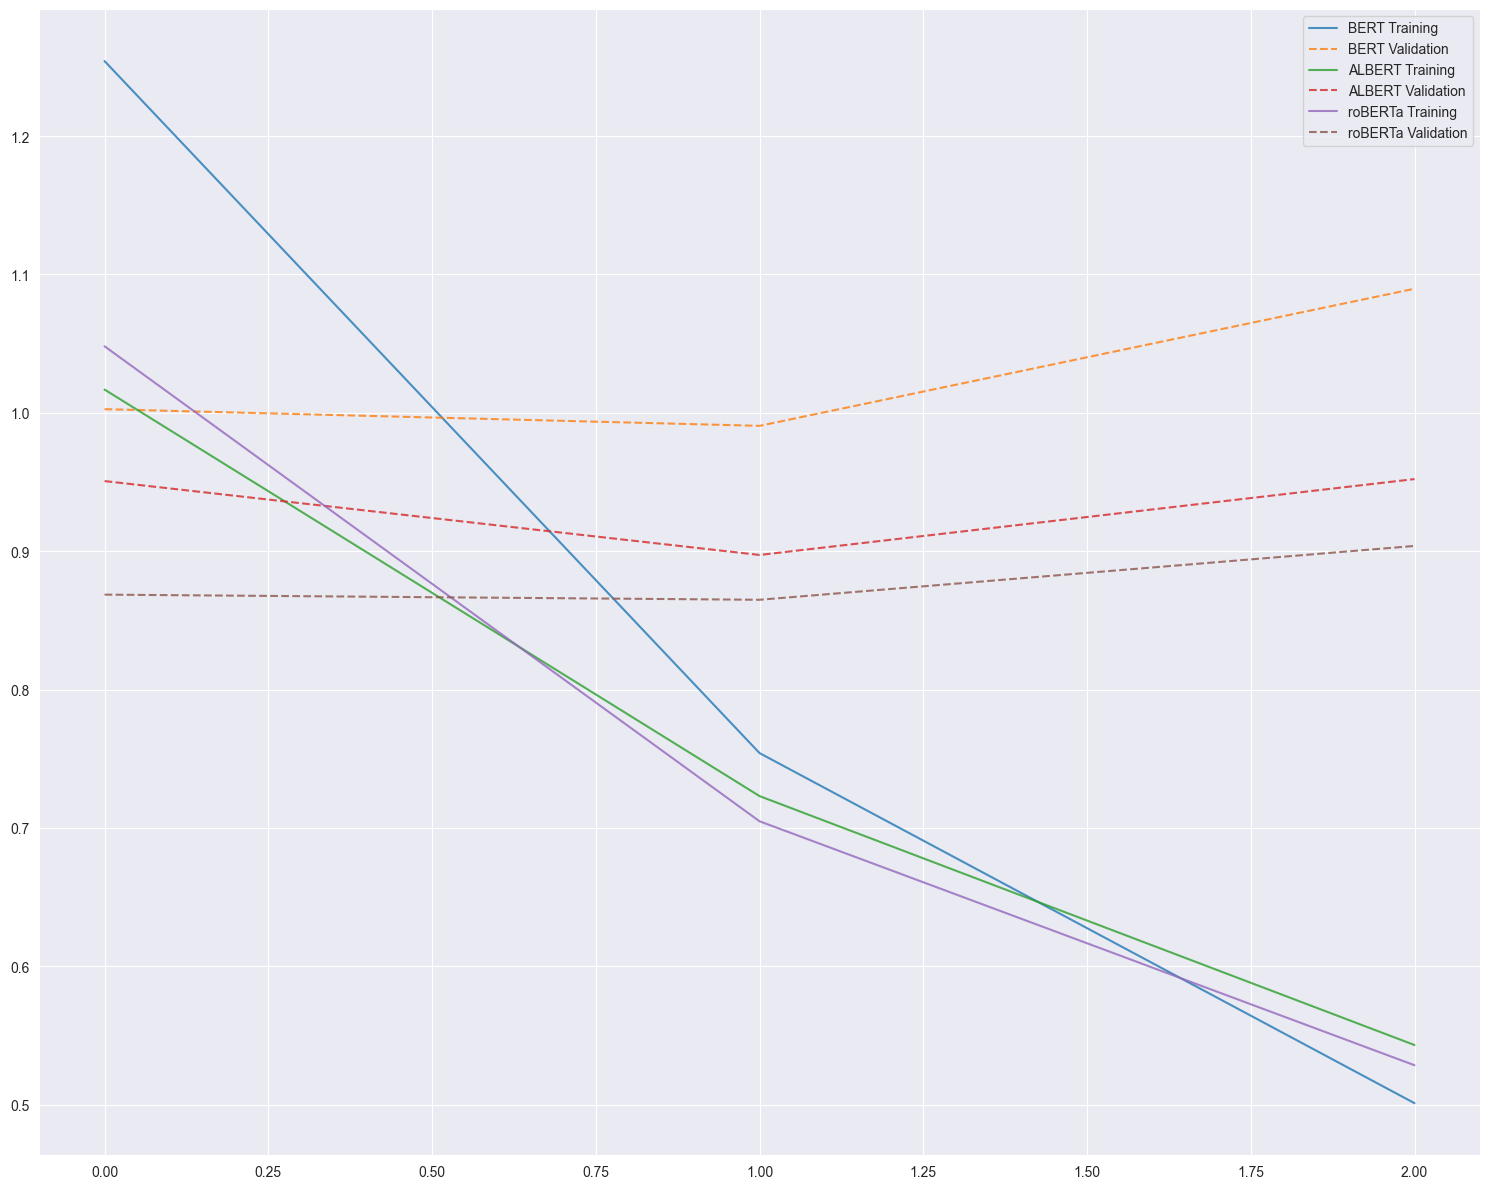

In [6]:
import pickle
import json
#import transformers
import matplotlib.pyplot as plt

with open('../Notebook Outputs/model_history_bert.pkl', 'rb') as f:
    history_bert = pickle.load(f)

with open('../Notebook Outputs/model_history_albert.pkl', 'rb') as f:
    history_albert = pickle.load(f)

with open('../Notebook Outputs/model_history_roberta.pkl', 'rb') as f:
    history_roberta = pickle.load(f)

def plot_training_history(histories, model_names, save_path=None):
    """
    Plot training and validation loss/accuracy for multiple models
    """
    fig, axes = plt.subplots(1, 1, figsize=(15, 12))

    # Training Loss
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes.plot(history['loss'], label=f'{name} Training', alpha=0.8)
        if 'val_loss' in history:
            axes.plot(history['val_loss'], label=f'{name} Validation', linestyle='--', alpha=0.8)
        plt.legend()

    # axes[0, 0].set_title('Training and Validation Loss')
    # axes[0, 0].set_xlabel('Epoch')
    # axes[0, 0].set_ylabel('Loss')
    # axes[0, 0].legend()
    # axes[0, 0].grid(True, alpha=0.3)
    #
    # # Training Accuracy (if available)
    # for i, (history, name) in enumerate(zip(histories, model_names)):
    #     if 'accuracy' in history:
    #         axes[0, 1].plot(history['accuracy'], label=f'{name} Training', alpha=0.8)
    #     if 'val_accuracy' in history:
    #         axes[0, 1].plot(history['val_accuracy'], label=f'{name} Validation', linestyle='--', alpha=0.8)
    #
    # axes[0, 1].set_title('Training and Validation Accuracy')
    # axes[0, 1].set_xlabel('Epoch')
    # axes[0, 1].set_ylabel('Accuracy')
    # axes[0, 1].legend()
    # axes[0, 1].grid(True, alpha=0.3)
    #
    # # Learning Rate (if available)
    # for i, (history, name) in enumerate(zip(histories, model_names)):
    #     if 'lr' in history:
    #         axes[1, 0].plot(history['lr'], label=name, alpha=0.8)
    #
    # axes[1, 0].set_title('Learning Rate Schedule')
    # axes[1, 0].set_xlabel('Epoch')
    # axes[1, 0].set_ylabel('Learning Rate')
    # axes[1, 0].legend()
    # axes[1, 0].grid(True, alpha=0.3)
    # axes[1, 0].set_yscale('log')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

plot_training_history([history_bert, history_albert, history_roberta], ['BERT', 'ALBERT', 'roBERTa'], '../')